In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import os
import json
import tarfile
import shutil
import zipfile
import random
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Define dataset paths
dataset_tar_path = "/content/drive/MyDrive/ROAD DAMAGE DATASET.tar"
dataset_zip_path = "/content/drive/MyDrive/archive (3).zip"
dataset_extract_path1 = "/content/road_damage_dataset1"
dataset_extract_path2 = "/content/road_damage_dataset2"
yolo_dataset_path = "/content/yolo_road_damage"

In [5]:
# Extract tar dataset
if not os.path.exists(dataset_extract_path1):
    with tarfile.open(dataset_tar_path, 'r') as tar:
        tar.extractall(dataset_extract_path1)

# Extract zip dataset
if not os.path.exists(dataset_extract_path2):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_extract_path2)

In [6]:
import os

# Paths for extracted dataset directories
img_dir1 = os.path.join(dataset_extract_path1, "ds0", "img")
dataset2_base = os.path.join(dataset_extract_path2, "dataset", "dataset", "classes")

# Count images in Dataset 1
img_count1 = len([f for f in os.listdir(img_dir1) if f.lower().endswith(".jpeg")]) if os.path.exists(img_dir1) else 0

# Count images in Dataset 2 (Recursively search inside class folders)
img_count2 = 0
for root, _, files in os.walk(dataset2_base):
    img_count2 += sum(1 for f in files if f.lower().endswith(".jpg") or f.lower().endswith(".jpeg"))

print(f"Extracted images from Dataset 1: {img_count1}")
print(f"Extracted images from Dataset 2: {img_count2}")
print(f"Total extracted images: {img_count1 + img_count2}")

Extracted images from Dataset 1: 3321
Extracted images from Dataset 2: 818
Total extracted images: 4139


In [7]:
# Define paths for dataset1 (TAR)
img_dir1 = os.path.join(dataset_extract_path1, "ds0", "img")
ann_dir1 = os.path.join(dataset_extract_path1, "ds0", "ann")

# Define paths for dataset2 (ZIP) - Assuming images & labels are directly inside
dataset2_base = os.path.join(dataset_extract_path2, "dataset", "dataset", "classes")

In [8]:
# Create YOLO dataset directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(yolo_dataset_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, split, "labels"), exist_ok=True)

In [9]:
# Convert TAR dataset annotations to YOLO format
dataset = []
image_files1 = os.listdir(img_dir1)
import os

img_dir1 = "/content/road_damage_dataset1/ds0/img"
img_files = [f for f in os.listdir(img_dir1) if f.lower().endswith(".jpeg")]
print(f"Total images found: {len(img_files)}")

# ✅ Process Dataset1 (TAR)
for img_file in tqdm(os.listdir(img_dir1)):
    json_file = os.path.join(ann_dir1, img_file + ".json")
    if not os.path.exists(json_file):
        continue

    with open(json_file, "r") as f:
        ann_data = json.load(f)

    yolo_labels = []
    img_path = os.path.join(img_dir1, img_file)
    if not os.path.exists(img_path):
        print(f"⚠️ Missing Image: {img_path}")
        continue  # Skip this image

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read image: {img_path}")
        continue  # Skip this image

    h, w, _ = img.shape  # Now safe to access shape


    for obj in ann_data["objects"]:
        bbox = obj["points"]["exterior"]
        x_min, y_min = bbox[0]
        x_max, y_max = bbox[1]

        x_center = ((x_min + x_max) / 2) / w
        y_center = ((y_min + y_max) / 2) / h
        bbox_width = (x_max - x_min) / w
        bbox_height = (y_max - y_min) / h

        yolo_labels.append(f"0 {x_center} {y_center} {bbox_width} {bbox_height}\n")  # No class mapping

    if yolo_labels:
        dataset.append((img_path, yolo_labels))

Total images found: 3321


100%|██████████| 3321/3321 [00:57<00:00, 57.76it/s]


In [10]:
# ✅ Base paths for Dataset2
image_folder = "/content/road_damage_dataset2/dataset/dataset/classes/"
dataset2_img_count = 0

for root, _, files in os.walk(image_folder):  # Traverse image directories
    if "images" not in root:
        continue  # Skip non-image directories

    for img_file in files:
        if not img_file.endswith(".jpg"):
            continue  # Skip non-image files

        img_path = os.path.join(root, img_file)

        # 🔍 Locate correct label path
        label_dir = root.replace("images", "labels/txt")  # Adjust path to label folder
        label_name = img_file.replace(".jpg", ".txt")
        label_path = os.path.join(label_dir, label_name)

        if not os.path.exists(label_path):
            print(f"⚠️ Missing label for {img_path}")  # Debug missing labels
            continue  # Skip if annotation is missing

        with open(label_path, "r") as f:
            yolo_labels = f.readlines()  # Read YOLO formatted labels

        dataset.append((img_path, yolo_labels))  # ✅ Add Dataset2 images
        dataset2_img_count += 1

# ✅ Debugging
print(f"Dataset2 images added: {dataset2_img_count}")
print(f"Total images collected after merging both datasets: {len(dataset)}")

⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7816.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7907.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7911.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7812.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7712.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7817.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7618.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7719.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images/7627.jpg
⚠️ Missing label for /content/road_damage_dataset2/dataset/dataset/classes/good_road/images

In [11]:
import os
import shutil

# Path to the folder with unlabeled images
unlabeled_folder1 = "/content/road_damage_dataset2/dataset/dataset/classes/pothole/valid_pothole_images"
unlabeled_folder2 = "/content/road_damage_dataset2/dataset/dataset/classes/good_road/images"

# Remove all images in the folder
if os.path.exists(unlabeled_folder1):
    for file in os.listdir(unlabeled_folder1):
        file_path = os.path.join(unlabeled_folder1, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
if os.path.exists(unlabeled_folder2):
    for file in os.listdir(unlabeled_folder2):
        file_path = os.path.join(unlabeled_folder2, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

    print("Unlabeled images removed successfully.")
else:
    print("Folder not found. Check the path.")

Unlabeled images removed successfully.


In [12]:
# ✅ Continue with dataset splitting (train, val, test)
random.shuffle(dataset)
n_train = int(0.8 * len(dataset))
n_val = int(0.1 * len(dataset))
train_set, val_set, test_set = dataset[:n_train], dataset[n_train:n_train+n_val], dataset[n_train+n_val:]

print(f"Final Split: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")

Final Split: Train=3151, Val=393, Test=395


In [13]:
# ✅ Copy images & labels to YOLO dataset
for split_name, data_split in zip(['train', 'val', 'test'], [train_set, val_set, test_set]):
    for img_path, labels in data_split:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(yolo_dataset_path, split_name, "images", img_name))

        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(yolo_dataset_path, split_name, "labels", label_name)

        with open(label_path, "w") as f:
            f.writelines(labels)

In [14]:
import os
import shutil
import hashlib

# Directories where images are stored
train_dir = "/content/yolo_road_damage/train/images"
val_dir = "/content/yolo_road_damage/val/images"
test_dir = "/content/yolo_road_damage/test/images"

# Dictionary to store hashes
image_hashes = {}
duplicate_files = []

def hash_image(image_path):
    """Generate a hash for an image file."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Function to check duplicates
def check_duplicates(directory):
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isfile(img_path):  # Ensure it's a file
            img_hash = hash_image(img_path)

            if img_hash in image_hashes:
                duplicate_files.append(img_path)
            else:
                image_hashes[img_hash] = img_path

# Check for duplicates in all sets
check_duplicates(train_dir)
check_duplicates(val_dir)
check_duplicates(test_dir)

# Print duplicates
print(f"Total duplicate images found: {len(duplicate_files)}")
print("Some duplicates:", duplicate_files[:10])  # Show first 10 duplicates

Total duplicate images found: 27
Some duplicates: ['/content/yolo_road_damage/train/images/31.jpg', '/content/yolo_road_damage/train/images/1040.jpg', '/content/yolo_road_damage/train/images/89.jpg', '/content/yolo_road_damage/train/images/1016.jpg', '/content/yolo_road_damage/train/images/622.jpg', '/content/yolo_road_damage/train/images/1075.jpg', '/content/yolo_road_damage/train/images/1152.jpg', '/content/yolo_road_damage/train/images/540.jpg', '/content/yolo_road_damage/train/images/202.jpg', '/content/yolo_road_damage/train/images/228.jpg']


In [15]:
for duplicate in duplicate_files:
    os.remove(duplicate)

print("Duplicates removed successfully.")

Duplicates removed successfully.


In [16]:
# Count images in extracted folders
num_images1 = len(os.listdir(img_dir1))
num_images2 = sum([len(files) for _, _, files in os.walk(dataset2_base) if any(f.endswith(".jpg") for f in files)])
print(f"Total images from Dataset1 (TAR): {num_images1}")
print(f"Total images from Dataset2 (ZIP): {num_images2}")
print(f"Total images collected: {len(dataset)}")  # Should match num_images1 + num_images2

# Count images in YOLO dataset splits
num_train = len(os.listdir(os.path.join(yolo_dataset_path, "train", "images")))
num_val = len(os.listdir(os.path.join(yolo_dataset_path, "val", "images")))
num_test = len(os.listdir(os.path.join(yolo_dataset_path, "test", "images")))

print(f"Train images: {num_train}")
print(f"Validation images: {num_val}")
print(f"Test images: {num_test}")

# Verify if counts match dataset split
print(f"Total in train/val/test: {num_train + num_val + num_test}")

Total images from Dataset1 (TAR): 3321
Total images from Dataset2 (ZIP): 621
Total images collected: 3939
Train images: 3133
Validation images: 388
Test images: 391
Total in train/val/test: 3912


In [17]:
print(f"Dataset1 images added: {len(os.listdir(img_dir1))}")
print(f"Dataset2 images added: {dataset2_img_count}")
print(f"Total images collected after merging both datasets: {len(dataset)}")

Dataset1 images added: 3321
Dataset2 images added: 618
Total images collected after merging both datasets: 3939


In [18]:
from pathlib import Path

base = Path("/content/yolo_road_damage")
for split in ["train", "val", "test"]:
    label_dir = base / split / "labels"
    for txt_file in label_dir.glob("*.txt"):
        lines = txt_file.read_text().splitlines()
        new = []
        for line in lines:
            parts = line.split()
            if len(parts) >= 5:
                # force class ID to 0, keep the bbox coords
                parts[0] = "0"
                new.append(" ".join(parts))
        txt_file.write_text("\n".join(new))

In [19]:
import random
from pathlib import Path

# Define the base path where your dataset is located
base = Path("/content/yolo_road_damage")

# Randomly select one file from the train, val, or test sets
split = random.choice(["train", "val", "test"])
label_dir = base / split / "labels"

# List all the .txt label files in the chosen split
label_files = list(label_dir.glob("*.txt"))

# Pick a random label file
random_label_file = random.choice(label_files)

# Read and print the contents of the selected label file
with open(random_label_file, "r") as f:
    print(f"Checking label file: {random_label_file}")
    lines = f.readlines()
    for line in lines:
        print(line.strip())

Checking label file: /content/yolo_road_damage/val/labels/Y_50150.txt
0 0.45026041666666666 0.812037037037037 0.18177083333333333 0.2462962962962963
0 0.29583333333333334 0.8555555555555555 0.23125 0.012962962962962963
0 0.5052083333333334 0.8546296296296296 0.08958333333333333 0.007407407407407408


In [20]:
# Create YAML file for YOLO training
data_yaml = """train: /content/yolo_road_damage/train/images
val: /content/yolo_road_damage/val/images
test: /content/yolo_road_damage/test/images

nc: 1
names:
  0: damage

"""

with open("/content/yolo_road_damage/data.yaml", "w") as f:
    f.write(data_yaml)

In [21]:
# Train YOLOv8 model
model = YOLO("yolov8m.pt")
model.train(data="/content/yolo_road_damage/data.yaml", epochs=50, imgsz=640, batch=32, augment=True)

100%|██████████| 49.7M/49.7M [00:00<00:00, 290MB/s]


Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolo_road_damage/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 21.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192,

100%|██████████| 5.35M/5.35M [00:00<00:00, 88.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1592.8±652.6 MB/s, size: 354.3 KB)


train: Scanning /content/yolo_road_damage/train/labels... 3133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3133/3133 [00:01<00:00, 2080.54it/s]

train: /content/yolo_road_damage/train/images/H_700.jpeg: 1 duplicate labels removed


train: New cache created: /content/yolo_road_damage/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1670.2±1228.3 MB/s, size: 588.3 KB)


val: Scanning /content/yolo_road_damage/val/labels... 388 images, 0 backgrounds, 0 corrupt: 100%|██████████| 388/388 [00:00<00:00, 1342.66it/s]


val: New cache created: /content/yolo_road_damage/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.3G      2.254      2.725      1.812        105        640: 100%|██████████| 98/98 [01:55<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]

                   all        388        725     0.0034      0.167    0.00207   0.000761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.8G      2.398      2.372       1.94        101        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


                   all        388        725      0.178       0.19     0.0812     0.0258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.2G      2.344      2.292      1.908        105        640: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


                   all        388        725     0.0267      0.183     0.0128    0.00452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.8G      2.264      2.213       1.86         98        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        388        725      0.257      0.174      0.125     0.0466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.1G      2.204      2.101      1.824        124        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


                   all        388        725       0.32      0.258      0.208     0.0804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.8G      2.168       2.02      1.768        134        640: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all        388        725      0.352      0.338      0.263      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.2G      2.108      1.971      1.742         92        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        388        725      0.368      0.326      0.282      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.7G      2.087      1.917      1.714        103        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


                   all        388        725      0.372      0.345      0.288      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.2G      2.062      1.884      1.699         99        640: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


                   all        388        725      0.421      0.368      0.318      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.8G      2.016      1.851      1.662        119        640: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


                   all        388        725      0.444      0.385      0.352      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.1G      1.981      1.806      1.645        111        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


                   all        388        725      0.415      0.397      0.348      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.8G      1.974      1.773      1.629         88        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


                   all        388        725      0.473      0.386      0.364      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.2G      1.948      1.739      1.605         99        640: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all        388        725      0.448      0.418      0.385      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.8G      1.928      1.713      1.589        107        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        388        725      0.519      0.366      0.381       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.1G        1.9      1.681       1.57        112        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


                   all        388        725      0.539      0.401      0.407      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.8G      1.898      1.649      1.566        108        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


                   all        388        725      0.555      0.436      0.455      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.1G      1.865      1.616      1.538        100        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]

                   all        388        725      0.556      0.423      0.427      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.8G      1.852      1.578      1.539        107        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        388        725      0.515      0.432      0.436      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.2G      1.838      1.568      1.521        101        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        388        725      0.542      0.477      0.478      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.8G       1.82      1.527        1.5        104        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        388        725      0.513      0.508       0.48      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.1G      1.817      1.506      1.508        112        640: 100%|██████████| 98/98 [01:49<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


                   all        388        725      0.536      0.473      0.482      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.7G      1.792      1.485      1.489        110        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]

                   all        388        725      0.506      0.434      0.434      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.1G      1.782      1.469      1.488        117        640: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


                   all        388        725      0.553      0.511      0.476      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.8G      1.764      1.442       1.47         81        640: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


                   all        388        725       0.57       0.48      0.497      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.1G      1.738       1.41      1.458         94        640: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        388        725      0.562      0.498      0.514      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.8G      1.748      1.393      1.453        100        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]

                   all        388        725       0.58      0.491      0.517      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.1G       1.71      1.365      1.439        128        640: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        388        725      0.595       0.47      0.496      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.8G      1.709      1.353      1.432        112        640: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        388        725       0.54       0.52      0.509      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.1G      1.701      1.337      1.433        117        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]

                   all        388        725      0.594      0.487      0.518      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.8G      1.669      1.291      1.411        122        640: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        388        725      0.551      0.545      0.531      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.1G      1.677      1.291      1.407        103        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

                   all        388        725      0.601       0.56      0.563      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.8G       1.67       1.28      1.403        147        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

                   all        388        725      0.567      0.534      0.547      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.2G      1.626      1.239      1.376         81        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        388        725      0.584      0.538      0.549       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.7G      1.622      1.235      1.385         85        640: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        388        725      0.559      0.561      0.565      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.1G       1.61       1.21      1.377        109        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

                   all        388        725      0.628      0.528      0.556      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.8G      1.608      1.196       1.37        117        640: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        388        725      0.592       0.55      0.561      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.2G      1.589      1.171      1.357         84        640: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        388        725      0.596      0.575      0.568      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.7G      1.564      1.149      1.353        122        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        388        725      0.599      0.566      0.569      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.1G      1.544      1.134       1.33        106        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        388        725      0.615      0.586      0.603      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.8G       1.54      1.108      1.328         92        640: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        388        725      0.617      0.571      0.592      0.286


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.1G      1.545      1.103      1.343         60        640: 100%|██████████| 98/98 [01:49<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        388        725      0.611      0.617      0.596      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.8G      1.496      1.027      1.326         54        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        388        725      0.637      0.588        0.6      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.1G      1.482      1.008      1.307         55        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

                   all        388        725      0.605      0.601      0.601      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.7G      1.459     0.9774      1.291         53        640: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        388        725       0.62       0.61      0.608      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.1G       1.44     0.9598      1.287         64        640: 100%|██████████| 98/98 [01:42<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        388        725       0.62       0.61      0.611      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.7G      1.424     0.9371      1.272         52        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


                   all        388        725      0.633      0.628      0.614      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.1G      1.401      0.917      1.264         60        640: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        388        725      0.638       0.64      0.636      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.7G      1.384     0.8914      1.248         66        640: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        388        725      0.636      0.645      0.625      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.1G      1.378     0.8881       1.25         53        640: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        388        725      0.665       0.65      0.652      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.7G      1.363     0.8747      1.242         65        640: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        388        725       0.66      0.641      0.647      0.309



50 epochs completed in 1.631 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


                   all        388        725      0.601      0.645      0.641      0.328
Speed: 0.2ms preprocess, 16.9ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78acfdf9bdd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [22]:
model.save("/content/runs/detect/train/weights/best.pt")

In [25]:
# 1. Load your trained YOLOv8 model
model = YOLO("/content/runs/detect/train/weights/best.pt")  # Make sure this path points to your final trained weights

# 2. Run evaluation on the validation set
val_results = model.val(data='/content/yolo_road_damage/data.yaml')  # Replace with your correct data.yaml path

# 3. Run evaluation on the training set (optional, to check overfitting)
train_results = model.val(data='/content/yolo_road_damage/data.yaml', split='train')

# 4. Run evaluation on the test set
test_results = model.val(data='/content/yolo_road_damage/data.yaml', split='test')

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3003.1±542.5 MB/s, size: 532.6 KB)


val: Scanning /content/yolo_road_damage/val/labels.cache... 388 images, 0 backgrounds, 0 corrupt: 100%|██████████| 388/388 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


                   all        388        725      0.663      0.646       0.65      0.314
Speed: 1.1ms preprocess, 11.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val7
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1683.2±1202.7 MB/s, size: 232.2 KB)


val: Scanning /content/yolo_road_damage/train/labels.cache... 3133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3133/3133 [00:00<?, ?it/s]

train: /content/yolo_road_damage/train/images/H_700.jpeg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [01:09<00:00,  2.83it/s]


                   all       3133       6258      0.842       0.75      0.841      0.523
Speed: 0.3ms preprocess, 11.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val8
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2475.8±940.3 MB/s, size: 500.9 KB)


val: Scanning /content/yolo_road_damage/test/labels.cache... 391 images, 0 backgrounds, 0 corrupt: 100%|██████████| 391/391 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


                   all        391        802      0.694      0.591      0.657      0.318
Speed: 0.6ms preprocess, 12.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val9


In [27]:
print("Validation Results:")
print(f"mAP@0.5: {val_results.box.map50:.3f}")
print(f"mAP@0.5:0.95: {val_results.box.map:.3f}")
print(f"Precision: {val_results.box.mp:.3f}")
print(f"Recall: {val_results.box.mr:.3f}")

print("\nTraining Results (optional):")
print(f"mAP@0.5: {train_results.box.map50:.3f}")
print(f"mAP@0.5:0.95: {train_results.box.map:.3f}")
print(f"Precision: {train_results.box.mp:.3f}")
print(f"Recall: {train_results.box.mr:.3f}")

print("\nTest Results:")
print(f"mAP@0.5: {test_results.box.map50:.3f}")
print(f"mAP@0.5:0.95: {test_results.box.map:.3f}")
print(f"Precision: {test_results.box.mp:.3f}")
print(f"Recall: {test_results.box.mr:.3f}")

Validation Results:
mAP@0.5: 0.650
mAP@0.5:0.95: 0.314
Precision: 0.663
Recall: 0.646

Training Results (optional):
mAP@0.5: 0.841
mAP@0.5:0.95: 0.523
Precision: 0.842
Recall: 0.750

Test Results:
mAP@0.5: 0.657
mAP@0.5:0.95: 0.318
Precision: 0.694
Recall: 0.591


In [28]:
# Run inference on test images
results = model.predict("/content/yolo_road_damage/test/images", save=True, conf=0.15)


image 1/391 /content/yolo_road_damage/test/images/100.jpg: 384x640 8 damages, 57.9ms
image 2/391 /content/yolo_road_damage/test/images/1014.jpg: 640x480 1 damage, 54.8ms
image 3/391 /content/yolo_road_damage/test/images/1029.jpg: 448x640 2 damages, 50.7ms
image 4/391 /content/yolo_road_damage/test/images/1033.jpg: 448x640 1 damage, 27.4ms
image 5/391 /content/yolo_road_damage/test/images/1034.jpg: 480x640 2 damages, 52.6ms
image 6/391 /content/yolo_road_damage/test/images/105.jpg: 480x640 1 damage, 28.0ms
image 7/391 /content/yolo_road_damage/test/images/1069.jpg: 480x640 2 damages, 28.0ms
image 8/391 /content/yolo_road_damage/test/images/108.jpg: 512x640 1 damage, 49.6ms
image 9/391 /content/yolo_road_damage/test/images/1088.jpg: 640x416 1 damage, 49.3ms
image 10/391 /content/yolo_road_damage/test/images/1095.jpg: 448x640 1 damage, 19.8ms
image 11/391 /content/yolo_road_damage/test/images/1104.jpg: 512x640 1 damage, 20.5ms
image 12/391 /content/yolo_road_damage/test/images/1105.jpg: 

In [29]:
# Load trained model & test on an image
test_image = "/content/crackdt.jpg"
model = YOLO("/content/runs/detect/train/weights/best.pt")
results = model(test_image, save=False, conf=0.2)


image 1/1 /content/crackdt.jpg: 640x640 2 damages, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


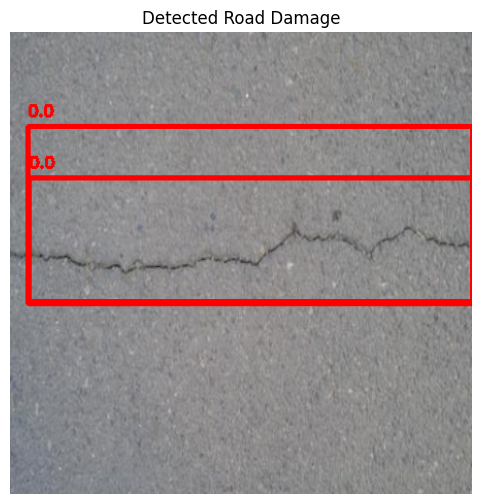

In [30]:
# Visualize results
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
        cv2.putText(image, f"{box.cls[0]}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Detected Road Damage")
plt.show()

Saving road11.jpeg to road11.jpeg
Uploaded: road11.jpeg

image 1/1 /content/road11.jpeg: 448x640 3 damages, 29.6ms
Speed: 3.7ms preprocess, 29.6ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)


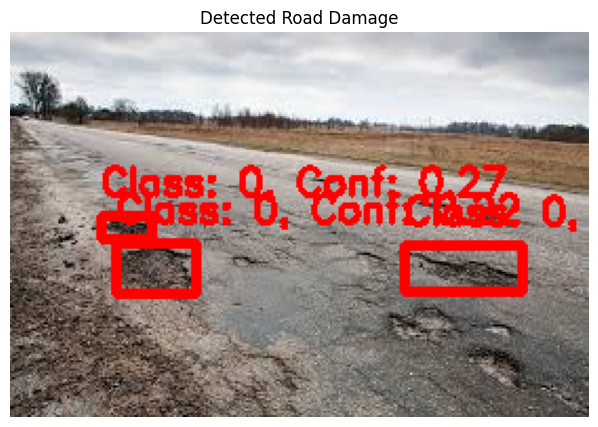

In [53]:
# 1. Upload image from local system
from google.colab import files
uploaded = files.upload()

# This gets the uploaded file path (assuming one image is uploaded)
import os
test_image = list(uploaded.keys())[0]
print("Uploaded:", test_image)

# 2. Load trained YOLO model
from ultralytics import YOLO
model = YOLO("/content/runs/detect/train/weights/best.pt")

# 3. Run inference on the uploaded image
results = model(test_image, save=False, conf=0.2)

# 4. Visualize the result with bounding boxes and class labels
import cv2
import matplotlib.pyplot as plt

# Load and convert image
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw bounding boxes
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])
        conf = float(box.conf[0])
        label = f"Class: {class_id}, Conf: {conf:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Display the result
plt.figure(figsize=(8, 5))
plt.imshow(image)
plt.axis("off")
plt.title("Detected Road Damage")
plt.show()

In [49]:
!cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/BOUNDING_BOXES_YOLO.pt